### Data import

In [341]:
import gzip
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

Here are some examples of MNIST digits:

![](Figures/mnist.png)

For convenience we'll the pickled dataset from deeplearningtutorial.net. The pickled file represents a tuple of 3 lists : the training set, the validation set and the testing set. Each of the three lists is a pair formed from a list of images and a list of class labels for each of the images. An image is represented as numpy 1-dimensional array of 784 (28 x 28) float values between 0 and 1 (0 stands for black, 1 for white). The labels are numbers between 0 and 9 indicating which digit the image represents.

In [323]:
# The pickle database is already formated as to output training, validation and test sets.
# We first uncompress on the fly to avoid keeping the uncompressed database on disk
pkl_file = gzip.open('Data/mnist.pkl.gz')
train_set, validation_set, test_set = pickle.load(pkl_file, encoding='latin1')
pkl_file.close()

# Now we create a single data set from all three subsets
X = np.concatenate([train_set[0], validation_set[0], test_set[0]])
y = np.concatenate([train_set[1], validation_set[1], test_set[1]])

In [13]:
# Each row of a data matrix is a digit, the following function will be useful to visualize them.
def view_digit(example):
    label = y[example]
    image = X[example,:].reshape([28, 28])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

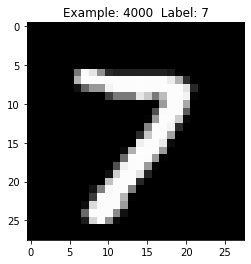

In [14]:
view_digit(4000)

In this section we'll work exclusively with the digit 3.

In [15]:
X3 = X[y == 3]

### Finding the principal components and visualizing the reconstruction

While we have implemented our own version of PCA using only numpy, here we will demonstrate how to use the PCA class of `sklearn.decomposition`. 

In [17]:
from sklearn.decomposition import PCA

# Lets keep only the first 49 principal components to make things quick.
# Initialize the class and obtain the components.
pca = PCA(n_components=49)
X_PCA = pca.fit_transform(X3)

Remember, the eigenvalues of the diagonalized covariance matrix represent the amount of variance each component explains. The sum of the first 49 eigenvalues, give us the total variance explained in the reduced dimensions. First we present a plot of the eigenvalues, next a plot of the accumulated variance explained up to component $i$.

In [19]:
# Percentage of Variance Captured by 49 principal components
print("Variance Explained by 49 principal components: ", sum(pca.explained_variance_ratio_))

Variance Explained by 49 principal components:  0.8378843127284199


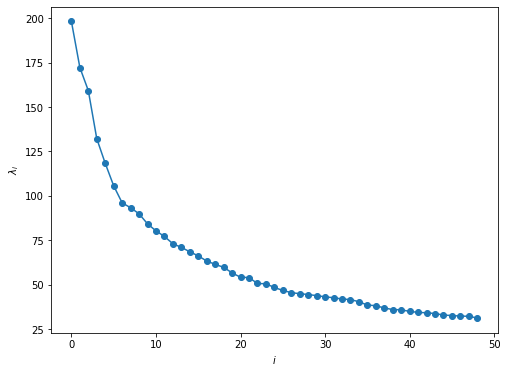

In [31]:
# Plot of the eigenvaluas of the covariance matrix
plt.figure(figsize=(8,6))
plt.plot(pca.explained_variance_, 'o-')
plt.ylabel(r'$\lambda_i$')
plt.xlabel(r'$i$');

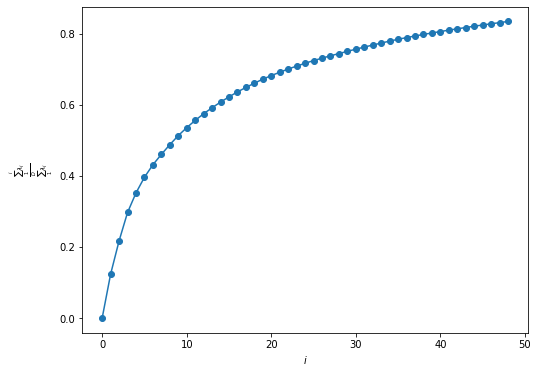

In [29]:
# Plot of the variance explaines by the first n components
var_list = [sum(pca.explained_variance_ratio_[:i]) for i in range(len(pca.explained_variance_ratio_))]
plt.figure(figsize=(8,6))
plt.plot(list(range(len(pca.explained_variance_ratio_))), var_list, '-o')
plt.xlabel(r'$i$')
plt.ylabel(r'$\frac{\sum_1^i\lambda_i}{\sum_1^D\lambda_i}$');

We now visualize the first two principal components together with key observations located at key quantiles along each component.

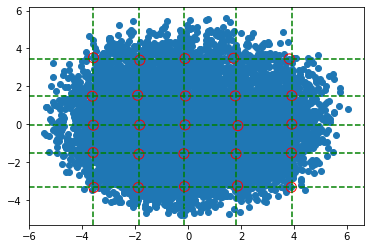

In [46]:
# Identify the 5%, 25%, 50%, 75%, 95% quantiles along both components
pc1 = X_PCA[:,0]
pc2 = X_PCA[:,1]

# Exact quantiles
qt1 = np.quantile(pc1, [0.05, 0.25, 0.5, 0.75, 0.95])
qt2 = np.quantile(pc2, [0.95, 0.75, 0.5, 0.25, 0.05])

# Plotting the first two principal components
plt.scatter(X_PCA[:,0], X_PCA[:,1])
# Quantile grid
for val in qt1:
    plt.axvline(val, color='green', linestyle='--')
for val in qt2:
    plt.axhline(val, color='green', linestyle='--')

# Nearest points to quantiles
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)
# Create list of nearest points starting at top left corner
examples = []
for (y, x) in product(qt2, qt1):
    closest = closest_node((x, y), list(zip(pc1, pc2)))
    examples.append(closest)
    plt.scatter(pc1[closest], pc2[closest], facecolors='none', edgecolors='r', s=100)

We now visualize the observations circled in red in an array of the same shape as in the plot. Note how moving left to right amounts to tilt the digit to the right (PC1), while moving top to bottom changes the shape of the lower lobe.

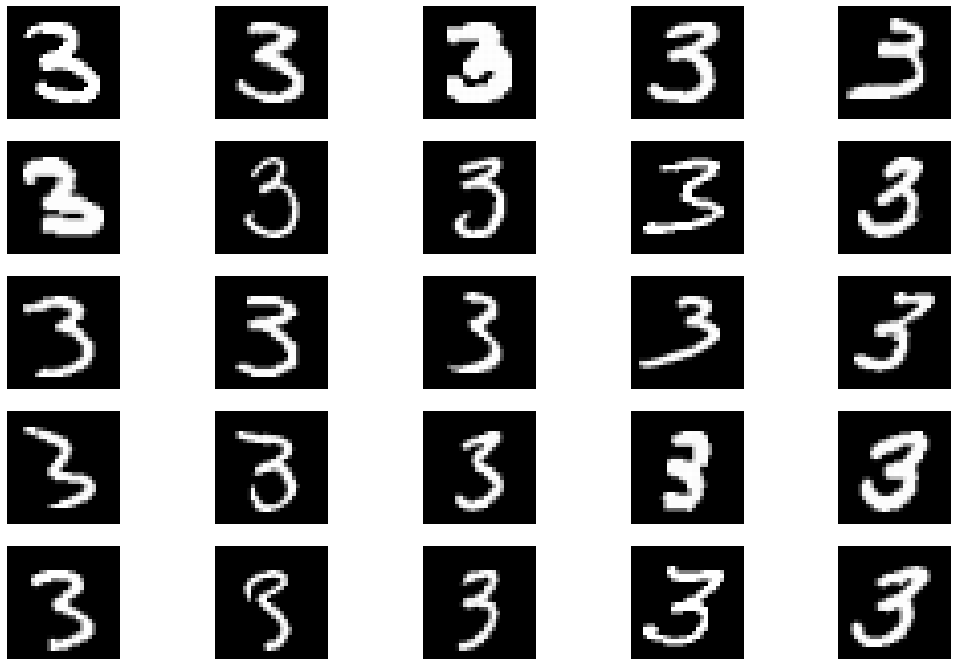

In [48]:
examples = np.array(examples).reshape(5,5)
fig, ax = plt.subplots(5, 5, figsize=(18,12))
for i, j in product(range(5), range(5)):
    image = X3[examples[i][j],:].reshape([28, 28])
    ax[i][j].axis('off')
    ax[i][j].imshow(image, cmap=plt.get_cmap('gray'))

To understand the effect of each component, we can think of each digit as a weighted sum of the unit vectors $u_i$, with the weights given by the principal components of each observation. Each $u_i$ can thus be interpreted as an image, and the weighted sum of such images reconstructs each digit. Below we plot the first 49 vectors $u_i$.

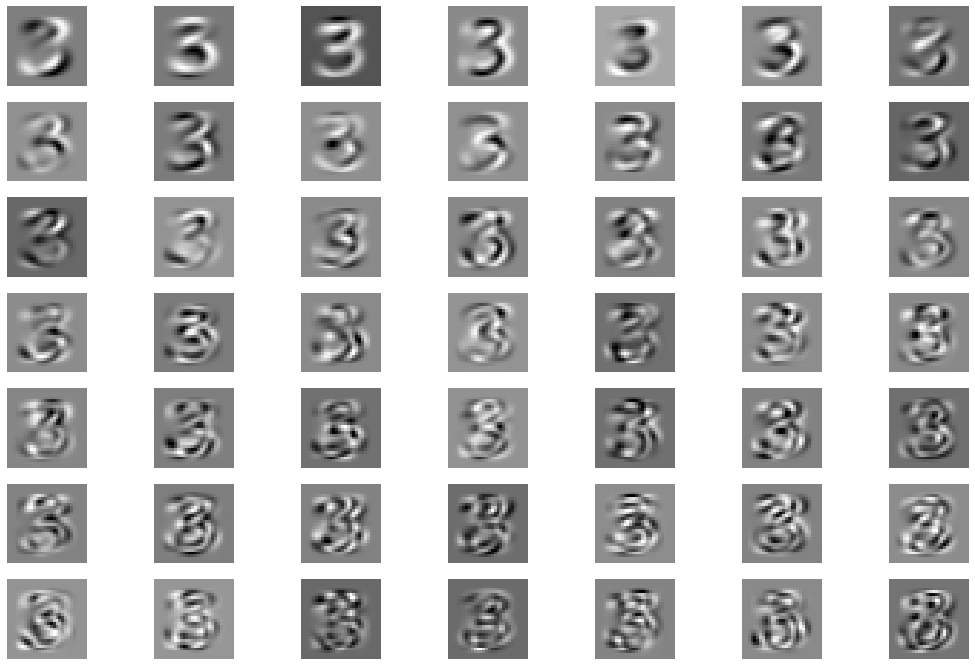

In [49]:
# A grid of the first 49 components
fig, ax = plt.subplots(7, 7, figsize=(18,12))
l = 0
for i, j in product(range(7), range(7)):    
    base = pca.components_[l].reshape([28, 28])
    ax[i][j].axis('off')
    ax[i][j].imshow(base, cmap=plt.get_cmap('gray'))
    l += 1

Focus in particular in the first two components and how they reflect the changes discussed before (tilt and shape).

To visualize the reconstruction, we begin with the mean and subsequently add the weighted components. Lets sum the first 3 components for a single example:

(-0.5, 27.5, 27.5, -0.5)

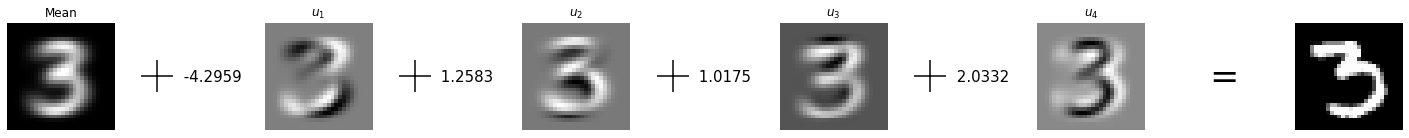

In [238]:
example = 100

X3_mean = np.mean(X3, axis=0)

fig, ax = plt.subplots(1, 11, figsize=(25,2))

ax[0].imshow(X3_mean.reshape([28,28]), cmap=plt.get_cmap('gray'))
ax[0].axis('off')
ax[0].set_title('Mean')

j = 0
for i in range(1, 9, 2):
    ax[i].scatter(0, 0, color='k', marker='+', s=1000)
    ax[i].text(0.05, -0.015, f' {X_PCA[example,j]:0.4f}', fontsize=15)
    ax[i].set_xlim(-0.05, 0.2)
    ax[i].axis('off')
    j += 1
    
j = 1
for i in range(2, 9, 2):
    ax[i].imshow(pca.components_[j-1].reshape([28,28]), cmap=plt.get_cmap('gray'))
    ax[i].axis('off')
    ax[i].set_title(rf'$u_{j}$')
    j += 1

ax[9].text(0.05, -0.04, '=', fontsize=35)
ax[9].set_xlim(-0.05, 0.2)
ax[9].set_ylim(-0.2, 0.2)
ax[9].axis('off')

ax[10].imshow(X3[example,:].reshape([28,28]), cmap=plt.get_cmap('gray'))
ax[10].axis('off')

Let's picture the same example at different levels of reconstruction:

In [250]:
import ipywidgets as widgets

def recons(m=0):
    rec = np.array(X3_mean, copy=True)  
    vec = X_PCA[example, :m]
    for i,l in enumerate(vec):
        rec += l * pca.components_[i]
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(X3[example,:].reshape([28,28]), cmap=plt.get_cmap('gray'))
    ax[0].axis('off')
    ax[0].set_title('Original')
    ax[1].imshow(rec.reshape([28,28]), cmap=plt.get_cmap('gray'))
    ax[1].set_title(f'Reconstructed from {m} components.')
    ax[1].axis('off');
    
widgets.interact(recons, m=(0,49,1));

interactive(children=(IntSlider(value=0, description='m', max=49), Output()), _dom_classes=('widget-interact',…

As M increases the reconstruction becomes more accurate and would become perfect when M = D = 28 × 28 = 784.

## Whitening

Previously, we have seen that we can individually scale features to zero mean and unit variance to remove the scaling effects from the dataset. Now we introduce a new transformation called **whitening** or **sphering**. After whitening, additionally to unit variance, the covariance among features is set to zero. To whiten an observation we define, for each data point $x_n$ , a transformed value given by
$$
y_n = L^{-1/2}U^T(x_n - \bar{x})
$$
where $U$ is the matrix with column eigenvectors from the PCA transform, and L is diagonalized covariance matrix.

It is easy to verify that this is just a PCA transform ($U^T x_n$) followed by normal standardization, since multiplying by $L^{-1/2}$ amounts to divide each columns by its standard deviation. Transforming all observations at once can be done by
$$
Y = XUL^{-1/2}
$$

To understand the difference, we'll use the classic Old Faithful dataset. The data set comprises 272 observations, each of which represents a single eruption and contains two variables corresponding to the duration in minutes of the eruption, and the time until the next eruption, also in minutes.

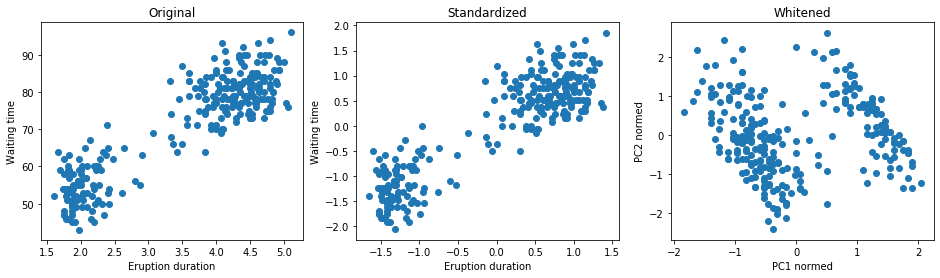

In [316]:
from sklearn.preprocessing import StandardScaler
old_f = np.loadtxt('Data/old-faithful.csv', delimiter=',')

fig, ax = plt.subplots(1, 3, figsize=(16,4))

# Original Data
ax[0].scatter(old_f[:,0], old_f[:,1])
ax[0].set_xlabel('Eruption duration')
ax[0].set_ylabel('Waiting time')
ax[0].set_title('Original')

# Standardizing
scaler = StandardScaler()
scaler.fit(old_f)
old_f_n = scaler.transform(old_f)
ax[1].scatter(old_f_n[:,0], old_f_n[:,1])
ax[1].set_xlabel('Eruption duration')
ax[1].set_ylabel('Waiting time')
ax[1].set_title('Standardized')
of_pca = PCA(n_components=2)
of_pca.fit(old_f_n)
pc1 = of_pca.components_[0]
pc2 = of_pca.components_[1]
l1, l2 = of_pca.explained_variance_
#ax[1].plot([],[],'-r')

# Whitened
of_pca = PCA(n_components=2)
old_f_w = of_pca.fit_transform(old_f)
L = np.diag(of_pca.explained_variance_)
old_f_w = old_f_w @ np.sqrt(np.linalg.inv(L))
ax[2].scatter(old_f_w[:,0], old_f_w[:,1])
ax[2].set_xlabel('PC1 normed')
ax[2].set_ylabel('PC2 normed')
ax[2].set_title('Whitened');


In [313]:
print('Y covariance matrix:')
print((old_f_w.T @ old_f_w)/len(old_f_w))

Y covariance matrix:
[[ 9.96323529e-01 -1.76329539e-16]
 [-1.76329539e-16  9.96323529e-01]]


## Visualization

We have previously tried to visualize the Iris data set using the first two principal components. It is also illustrative to study how this visualization performs in a dataset with much larger dimensionality. So now we plot the first two principal components of the MNIST data set for all digits. Visualization without dimensionality reduction in datasets with many dimensions is very hard. With PCA we hope to keep most of the structure of the dataset in the first 2 or 3 dimensions, which allows us to visually inspect such structure in search for, for example, clusters.

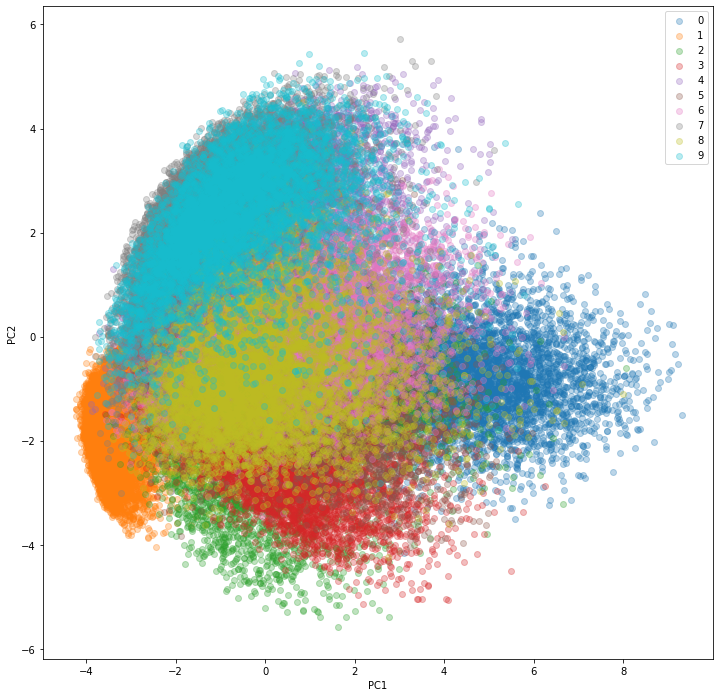

In [337]:
pca = PCA(n_components=3)
X_PCA = pca.fit_transform(X)
plt.figure(figsize=(12,12))
for i in range(10):
    Xd = X_PCA[y==i]
    plt.scatter(Xd[:,0], Xd[:,1], label=i, alpha=0.3)
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2');

In [342]:
%matplotlib widget

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
for i in range(10):
    Xd = X_PCA[y==i]
    ax.scatter(Xd[:,0], Xd[:,1], Xd[:,2], label=i, alpha=0.3)
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.ylabel('PC3');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …